<a href="https://colab.research.google.com/github/AkhandSingh96/Stock-Market-Prediction-Using-Deep-Learning-/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [ ]:
import numpy as np
import pandas as pd

# Dataset preparation and preprocessing

In [ ]:
!pip install yahoofinancials
!pip install yfinance

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp37-none-any.whl size=15192 sha256=735086d74f04c49e5527eaea2238ea85057ce2d82de08d029f6a6ae6c685dc32
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials
     |████████████████████████████████| 6.3MB 8.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=16d5fc1f446c02535c94fa2c871a1b22fbb700ec832f93597bd75784c81f55fc
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
import yfinance as yf

from yahoofinancials import YahooFinancials
MSFT = yf.download('MSFT', start='2013-01-01', end='2019-12-31',progress=False)

all_data = MSFT[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2013-01-02,23.13,27.25,27.73,27.15,27.62,52899300
2013-01-03,22.82,27.63,27.65,27.16,27.25,48294400
2013-01-04,22.39,27.27,27.34,26.73,26.74,52521100
2013-01-07,22.35,26.77,26.88,26.64,26.69,37110400
2013-01-08,22.23,26.75,26.79,26.46,26.55,44703100
2013-01-09,22.36,26.72,26.75,26.56,26.70,49047900
2013-01-10,22.16,26.65,26.98,26.29,26.46,71431300
2013-01-11,22.47,26.49,26.93,26.28,26.83,55512100
2013-01-14,22.52,26.90,27.08,26.76,26.89,48324400


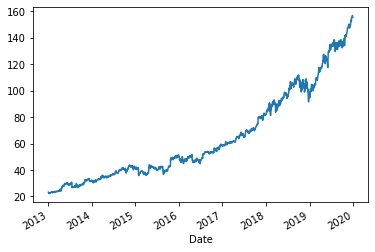

In [ ]:
all_data['Adj Close'].plot()

Comparing the train and test sizes.

<BarContainer object of 2 artists>

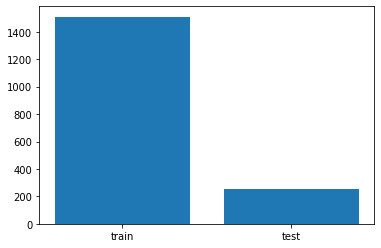

In [ ]:
import matplotlib.pyplot as plt
train = all_data[:'2018'].shape[0]
test = all_data['2019':].shape[0]
plt.bar(["train","test"],[train,test])

In [ ]:
def pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )
    


In this section we normalize the data using MinMaxScaler feature of sklearn library upto 5 timestamps.

In [ ]:
def normalize(all_data,time_steps,for_periods):
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test  = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc



In [ ]:
X_train, y_train, X_test, sc = normalize(all_data,5,2)

We split the training and testing data in the ratio 80:20.

In [ ]:
def train_test_split(all_data,time_steps,for_periods):
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test  = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

X_train, y_train, X_test = train_test_split(all_data,5,2)
X_train.shape[0],X_train.shape[1]

(1504, 5)

# GRU without regularizer model training.

(26.690552, <matplotlib.axes._subplots.AxesSubplot at 0x7f3c1fc77bd0>)

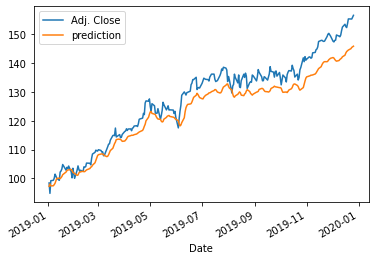

In [ ]:
def GRU_model(X_train, y_train, X_test, sc):
    
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from keras.optimizers import SGD
    
    
    GRU_model = Sequential()
    
    GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    
    GRU_model.add(GRU(units=50, activation='tanh'))
    GRU_model.add(Dense(units=2))

    
    GRU_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
     
    GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    GRU_prediction = GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return GRU_model, GRU_prediction

GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
pred_plot(GRU_prediction)

#GRU with regularizer model training.



(26.690552, <matplotlib.axes._subplots.AxesSubplot at 0x7f3c1d0d9150>)

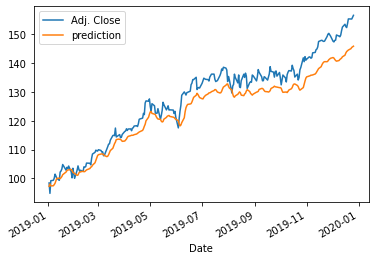

In [ ]:
def GRU_model_regularization(X_train, y_train, X_test, sc):
    
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from keras.optimizers import SGD
    from keras.layers import Dropout
    
    
    GRU_model = Sequential()
    
    
    GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    GRU_model.add(Dropout(0.2))
    
    
    GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    GRU_model.add(Dropout(0.2))
    

    
    GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    GRU_model.add(Dropout(0.2))

   
    GRU_model.add(GRU(units=50, activation='tanh'))
    GRU_model.add(Dropout(0.2))
    
    
    GRU_model.add(Dense(units=1))
  
    GRU_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    
    GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    GRU_predictions = GRU_model.predict(X_test)
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    return GRU_model, GRU_predictions

GRU_model, GRU_predictions = GRU_model_regularization(X_train, y_train, X_test, sc)
GRU_predictions[1:10]
pred_plot(GRU_prediction)